# AEMO DATA
##### Source : https://aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregated-data

## Install Libraries


In [4]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'tensorflow', 'sklearn', 'sktime', 'prophet']

for package in packages:
    try:
        __import__(package)  
    except ImportError:
        install(package)  

from IPython.display import clear_output

clear_output(wait=True)

print("All required packages are installed.")


All required packages are installed.


## Data Preparation

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '/Users/anup/Desktop/AEMO_DATA/Merged_PRICE_AND_DEMAND_VIC1.csv'
data = pd.read_csv(file_path)

data['SETTLEMENTDATE'] = pd.to_datetime(data['SETTLEMENTDATE'])

data.set_index('SETTLEMENTDATE', inplace=True)

data = data.fillna(method='ffill')

data = data[['TOTALDEMAND']]

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]


/var/folders/9q/gks6hc0d4_n68vl0rvys8pgw0000gn/T/ipykernel_15991/41148242.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


## Time Series Forecasting Using Scikit-learn

#### Convert Time Series to Supervised Data

In this approach, we will shift the data to create lagged features that represent past time steps as input features to predict future demand.

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def create_lagged_features(data, lag=3):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df_lagged = pd.concat(columns, axis=1)
    df_lagged.columns = [f'lag_{i}' for i in range(lag, 0, -1)] + ['target']
    return df_lagged.dropna()


lag_steps = 3
data_lagged = create_lagged_features(data['TOTALDEMAND'], lag=lag_steps)

train_size = int(len(data_lagged) * 0.8)
train_lagged, test_lagged = data_lagged.iloc[:train_size], data_lagged.iloc[train_size:]

X_train, y_train = train_lagged.iloc[:, :-1], train_lagged.iloc[:, -1]
X_test, y_test = test_lagged.iloc[:, :-1], test_lagged.iloc[:, -1]


#### Train a Linear Regression Model

In [7]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred)
print(f'Linear Regression Model MSE: {mse_linear:.2f}')


Linear Regression Model MSE: 3576.52


#### Plot Predictions

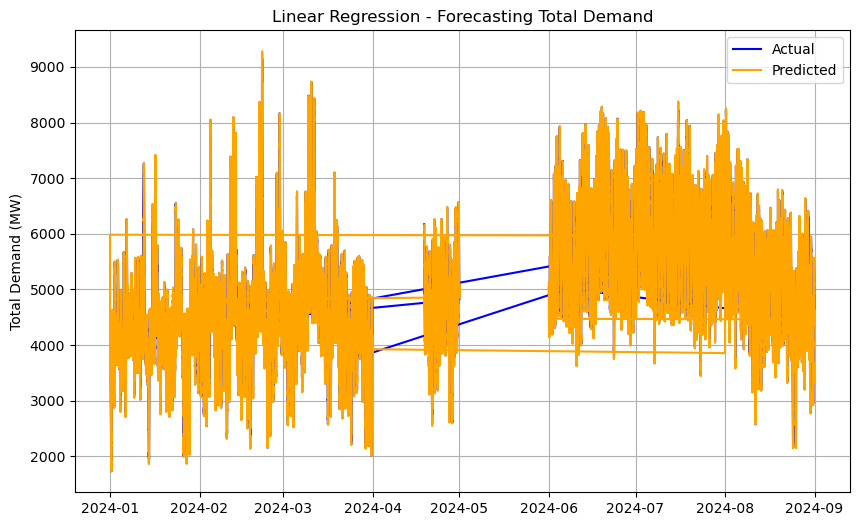

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='orange')
plt.title('Linear Regression - Forecasting Total Demand')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.grid(True)
plt.show()


#### Applying Gradient Boosting Models

Gradient Boosting Model MSE: 3125.22


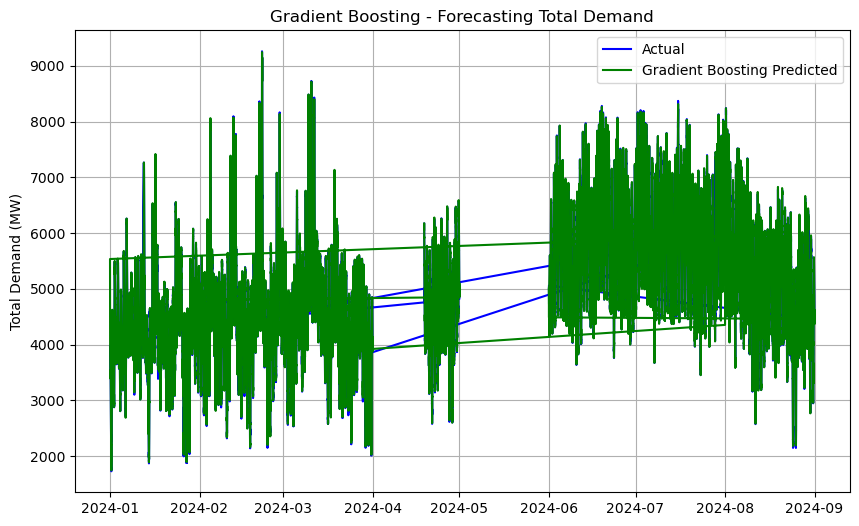

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(n_estimators=1000)
gbr_model.fit(X_train, y_train)

gbr_pred = gbr_model.predict(X_test)

mse_gbr = mean_squared_error(y_test, gbr_pred)
print(f'Gradient Boosting Model MSE: {mse_gbr:.2f}')

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
plt.plot(y_test.index, gbr_pred, label='Gradient Boosting Predicted', color='green')
plt.title('Gradient Boosting - Forecasting Total Demand')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.grid(True)
plt.show()


## ARIMA Model (Time Series)

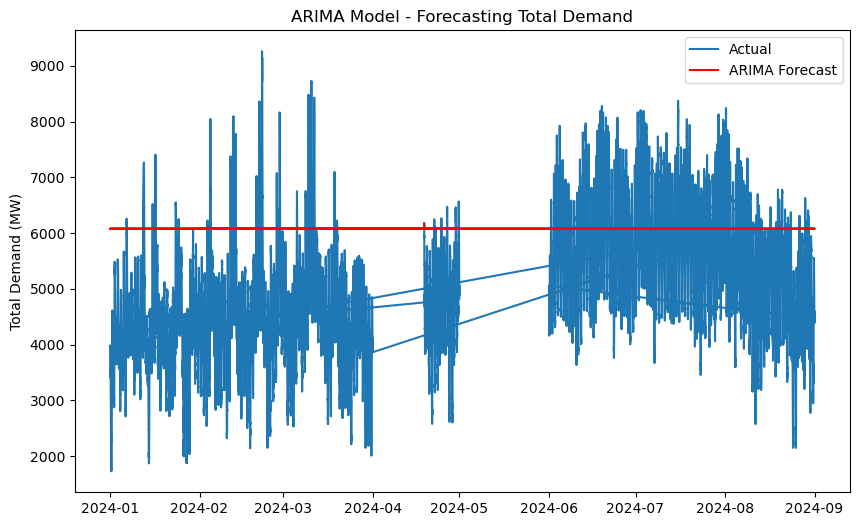

In [19]:
import statsmodels.api as sm

arima_model = sm.tsa.ARIMA(train, order=(5,1,0)) 
arima_fit = arima_model.fit()

arima_pred = arima_fit.forecast(steps=len(test))

plt.figure(figsize=(10,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_pred, label='ARIMA Forecast', color='red')
plt.title('ARIMA Model - Forecasting Total Demand')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.show()

## Neural Networks - LSTM for Demand Forecasting

Epoch 1/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 114s 32ms/step - loss: 0.0018
Epoch 2/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 106s 30ms/step - loss: 7.0386e-05
Epoch 3/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - loss: 6.2666e-05
Epoch 4/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 93s 26ms/step - loss: 5.8474e-05
Epoch 5/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - loss: 5.6685e-05
Epoch 6/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 92s 26ms/step - loss: 5.6404e-05
Epoch 7/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - loss: 5.5323e-05
Epoch 8/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 94s 27ms/step - loss: 5.2079e-05
Epoch 9/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 92s 26ms/step - loss: 5.2199e-05
Epoch 10/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - loss: 5.2456e-05
Epoch 11/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 91s 26ms/step - loss: 5.2735e-05
Epoch 12/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - loss: 5.1570e-05
Epoch 13/20
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - loss: 5.1963e-05
Epoch 14/20
3513/3513 ━

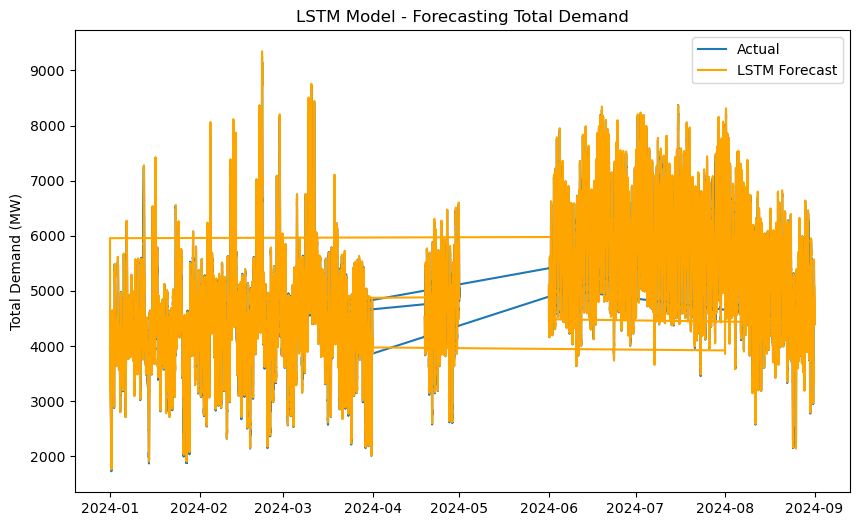

In [18]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

def create_dataset(X, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step - 1):
        Xs.append(X[i:(i + time_step), 0])
        ys.append(X[i + time_step, 0])
    return np.array(Xs), np.array(ys)

time_step = 60  
X_train, y_train = create_dataset(train_scaled, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))


lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X_train, y_train, batch_size=64, epochs=20)

test_scaled = scaler.transform(test)
X_test, y_test = create_dataset(test_scaled, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_pred = lstm_model.predict(X_test)

lstm_pred = scaler.inverse_transform(lstm_pred)

plt.figure(figsize=(10,6))
plt.plot(test.index[time_step+1:], test.values[time_step+1:], label='Actual')
plt.plot(test.index[time_step+1:], lstm_pred, label='LSTM Forecast', color='orange')
plt.title('LSTM Model - Forecasting Total Demand')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.show()


## Gradient Boosting Models (XGBoost)

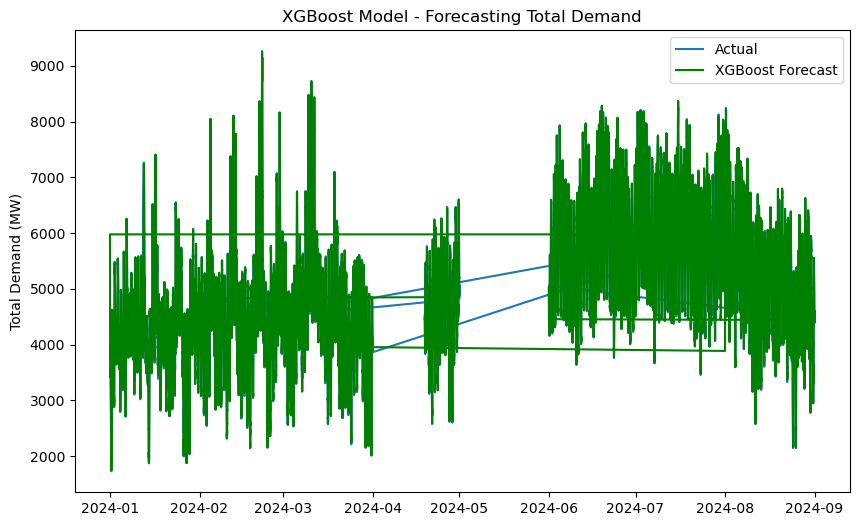

In [21]:
from xgboost import XGBRegressor

# Prepare data for XGBoost
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Fit the XGBoost model
xgb_model = XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)
xgb_pred = xgb_pred.reshape(-1, 1)

# Rescale predictions back to the original scale
xgb_pred = scaler.inverse_transform(xgb_pred)

# Plot actual vs XGBoost forecast
plt.figure(figsize=(10,6))
plt.plot(test.index[time_step+1:], test.values[time_step+1:], label='Actual')
plt.plot(test.index[time_step+1:], xgb_pred, label='XGBoost Forecast', color='green')
plt.title('XGBoost Model - Forecasting Total Demand')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.show()


## Model Evaluation

In [33]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for ARIMA model
mse_arima = mean_squared_error(test, arima_pred)
print(f'ARIMA Model MSE: {mse_arima:.2f}')

# Calculate MSE for LSTM model
mse_lstm = mean_squared_error(test[time_step+1:], lstm_pred)
print(f'LSTM Model MSE: {mse_lstm:.2f}')

# Calculate MSE for XGBoost model
mse_xgb = mean_squared_error(test[time_step+1:], xgb_pred)
print(f'XGBoost Model MSE: {mse_xgb:.2f}')



ARIMA Model MSE: 2616656.29
LSTM Model MSE: 6021.47
XGBoost Model MSE: 3880.45
